# Classification of images using PyTorch

## Reduction of dataset

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import copy
from PIL import Image
from pathlib import Path
from tqdm import tqdm


# Custom import
from source.dataset_reduction import extract_reduced_dataset, check_images_size_equal
from source.cnn_model import train_model, FlexibleCNN #,CNN
from source.plotting import plot_training_history, plot_random_predictions


# TO DO

figure: 

- title
- save
- folder


evaluvation metric


hyperparameter
- dynamic hyperparameter test
- what to choose? 
- randomized search
- depths vs nodes

save models

comment code

Test vs pre-built model
- use pre-built model as paper to read?

architechture
- add pooling and type to model generator

search "ML nodes UiO"
- apply for access
- 


data augmentation?

In [16]:
# Extract a reduced dataset for quick experiments
images_for_train_validate_test = 546   # 546 is all, extracts  smaller subset if given
classes_reduced = ['snail', 'wasp', 'moth']

dataset = extract_reduced_dataset(images_for_train_validate_test, classes_reduced)

Folder already exists: agropest12_reduced_546_images
Available datasets:
agropest12_reduced_546_images


In [17]:
# Check that images have equal size
check_images_size_equal(dataset)

All images have the same size: (640, 640)


## Prepare PyTorch model

In [18]:
# Create dataset and dataloaders

seed_value = 42
torch.manual_seed(seed_value)

transform = transforms.Compose([
    transforms.Resize((128,128)),  # 256,256 / 128,128 / 64,64
    transforms.ToTensor()
    ])

train_dataset = datasets.ImageFolder(root=dataset / 'train/images', transform=transform) # resize images if needed
test_dataset = datasets.ImageFolder(root=dataset / 'test/images', transform=transform) # resize images if needed
validation_dataset = datasets.ImageFolder(root=dataset / 'valid/images', transform=transform) # resize images if needed


if len(train_dataset) < 20:
    batch_size = 16
elif len(train_dataset) > 20 and len(train_dataset) < 100:
    batch_size = 32
else:
    batch_size = 64 


test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size, shuffle=True)


In [19]:
# Quality control of DataLoader
dataloader_verbose = True
if dataloader_verbose:
    ## Get one batch from DataLoader
    images, labels = next(iter(train_dataloader))

    print(f"Shape: {images.shape}")
    print(f'Scaled data in in range [0,1], values in loaded image are: [{images.min().item()}, {images.max().item()}]')
    print(f'Classes are: {train_dataset.class_to_idx}')
    #print(f'Targets are: {train_dataset.targets}')

Shape: torch.Size([64, 3, 128, 128])
Scaled data in in range [0,1], values in loaded image are: [0.0, 1.0]
Classes are: {'moth': 0, 'snail': 1, 'wasp': 2}


In [20]:
# Defining CNN model in PyTorch using nn.Module

from source.cnn_model import CNN, FlexibleCNN
input_size_img = tuple(images.shape[1:])  # (channels, height, width)
num_classes = torch.unique(torch.tensor(train_dataset.targets)).numel()

print(f'Images channel and size: {input_size_img}\nNumber of classes: {num_classes}')

Images channel and size: (3, 128, 128)
Number of classes: 3


In [21]:
# Manual CNN

#model_manual = CNN(num_classes, input_size=input_size_img)
#print(model_manual)


In [22]:
# Flexible CNN

print(input_size_img, num_classes)
# Example: LeakyReLU + BatchNorm enabled
model_flexible = FlexibleCNN(
    input_size=input_size_img,
    num_classes=num_classes,
    conv_layers=[(32, 3), (64, 3), (128, 3)],
    fc_layers=[256, 128],
    activation=nn.ReLU,    # Custom activation
    dropout_fc=0.3,             # Dropout in FC layers
    dropout_conv=0.1,           # Dropout in conv layers
    use_batchnorm=True,
    pool_type="avg",            # Use AvgPool instead of MaxPool
    global_pool="max"           # Use AdaptiveMaxPool for final pooling
)

"""
# Custom architecture:
model_flexible = FlexibleCNN(
    input_size=input_size_img,
    num_classes=num_classes,    # add Batchnorm2D? Uses BatchNorm2d for stability. AdaptiveAvgPool2d avoids huge fully connected layers.
    conv_layers=[(32, 5), (64, 5), (128, 5)], # (hidden_channels, kernels_size) for defining convolutional layers
    fc_layers=[512, 128], # defining fully connected layers
    activation=nn.ReLU,
    dropout=0.5
)

"""
print(model_flexible)

(3, 128, 128) 3
FlexibleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.1, inplace=False)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Dropout2d(p=0.1, inplace=False)
    (14): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (15): AdaptiveMaxPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Linear(in_features=128

In [23]:
# Model summary
from torchsummary import summary
summary(model_flexible, input_size=input_size_img)


# Alternative model summary
from torchinfo import summary
summary(model_flexible, input_size=images.shape, col_names=["input_size", "output_size", "num_params"])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         Dropout2d-4         [-1, 32, 128, 128]               0
         AvgPool2d-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
       BatchNorm2d-7           [-1, 64, 64, 64]             128
              ReLU-8           [-1, 64, 64, 64]               0
         Dropout2d-9           [-1, 64, 64, 64]               0
        AvgPool2d-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        Dropout2d-14          [-1, 128,

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
FlexibleCNN                              [64, 3, 128, 128]         [64, 3]                   --
├─Sequential: 1-1                        [64, 3, 128, 128]         [64, 128, 1, 1]           --
│    └─Conv2d: 2-1                       [64, 3, 128, 128]         [64, 32, 128, 128]        896
│    └─BatchNorm2d: 2-2                  [64, 32, 128, 128]        [64, 32, 128, 128]        64
│    └─ReLU: 2-3                         [64, 32, 128, 128]        [64, 32, 128, 128]        --
│    └─Dropout2d: 2-4                    [64, 32, 128, 128]        [64, 32, 128, 128]        --
│    └─AvgPool2d: 2-5                    [64, 32, 128, 128]        [64, 32, 64, 64]          --
│    └─Conv2d: 2-6                       [64, 32, 64, 64]          [64, 64, 64, 64]          18,496
│    └─BatchNorm2d: 2-7                  [64, 64, 64, 64]          [64, 64, 64, 64]          128
│    └─ReLU: 2-8             

In [10]:
# Train model

optimizer = torch.optim.Adam(model_flexible.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
epochs = 30

# Train with early stopping + scheduler
history = train_model(
    model=model_flexible,
    num_epochs=epochs,
    train_dl=train_dataloader,
    valid_dl=validation_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device='cpu',
    verbose=True,
    patience=5
)

Epoch [1/30] Train Loss: 1.0682, Train Acc: 0.4042 | Valid Loss: 1.1029, Valid Acc: 0.3674


Epoch [2/30] Train Loss: 1.0039, Train Acc: 0.4828 | Valid Loss: 1.1445, Valid Acc: 0.4053


Epoch [3/30] Train Loss: 0.9457, Train Acc: 0.5431 | Valid Loss: 1.2261, Valid Acc: 0.4356


Epoch [4/30] Train Loss: 0.8535, Train Acc: 0.5824 | Valid Loss: 0.7763, Valid Acc: 0.6932


Epoch [5/30] Train Loss: 0.7963, Train Acc: 0.6398 | Valid Loss: 0.9160, Valid Acc: 0.5795


Epoch [6/30] Train Loss: 0.8181, Train Acc: 0.6293 | Valid Loss: 0.7164, Valid Acc: 0.7197


Epoch [7/30] Train Loss: 0.7132, Train Acc: 0.6724 | Valid Loss: 0.6764, Valid Acc: 0.6970


Epoch [8/30] Train Loss: 0.6545, Train Acc: 0.6983 | Valid Loss: 0.6245, Valid Acc: 0.7462


Epoch [9/30] Train Loss: 0.6049, Train Acc: 0.7328 | Valid Loss: 0.6776, Valid Acc: 0.7083


Epoch [10/30] Train Loss: 0.6683, Train Acc: 0.7165 | Valid Loss: 0.6109, Valid Acc: 0.7955


Epoch [11/30] Train Loss: 0.6291, Train Acc: 0.7213 | Valid Loss: 0.6301, Valid Acc: 0.6970


Epoch [12/30] Train Loss: 0.5758, Train Acc: 0.7538 | Valid Loss: 0.7100, Valid Acc: 0.6970


Epoch [13/30] Train Loss: 0.5857, Train Acc: 0.7510 | Valid Loss: 0.6421, Valid Acc: 0.7386


Epoch [14/30] Train Loss: 0.5031, Train Acc: 0.7931 | Valid Loss: 0.5657, Valid Acc: 0.7424


Epoch [15/30] Train Loss: 0.4847, Train Acc: 0.8132 | Valid Loss: 0.4511, Valid Acc: 0.8333


Epoch [16/30] Train Loss: 0.4962, Train Acc: 0.7998 | Valid Loss: 0.5481, Valid Acc: 0.7841


Epoch [17/30] Train Loss: 0.4856, Train Acc: 0.7979 | Valid Loss: 0.4466, Valid Acc: 0.8371


Epoch [18/30] Train Loss: 0.4502, Train Acc: 0.8218 | Valid Loss: 0.4566, Valid Acc: 0.8295


Epoch [19/30] Train Loss: 0.4472, Train Acc: 0.8247 | Valid Loss: 0.4154, Valid Acc: 0.8447


Epoch [20/30] Train Loss: 0.4322, Train Acc: 0.8180 | Valid Loss: 0.4175, Valid Acc: 0.8523


Epoch [21/30] Train Loss: 0.4080, Train Acc: 0.8515 | Valid Loss: 0.4463, Valid Acc: 0.8106


Epoch [22/30] Train Loss: 0.3763, Train Acc: 0.8467 | Valid Loss: 0.3825, Valid Acc: 0.8750


Epoch [23/30] Train Loss: 0.3649, Train Acc: 0.8554 | Valid Loss: 0.3864, Valid Acc: 0.8712


Epoch [24/30] Train Loss: 0.3795, Train Acc: 0.8506 | Valid Loss: 0.4636, Valid Acc: 0.7992


Epoch [25/30] Train Loss: 0.3440, Train Acc: 0.8630 | Valid Loss: 0.3910, Valid Acc: 0.8636


Epoch [26/30] Train Loss: 0.3349, Train Acc: 0.8630 | Valid Loss: 0.3686, Valid Acc: 0.8598


Epoch [27/30] Train Loss: 0.2849, Train Acc: 0.8918 | Valid Loss: 0.3265, Valid Acc: 0.8750


Epoch [28/30] Train Loss: 0.3220, Train Acc: 0.8793 | Valid Loss: 0.3226, Valid Acc: 0.8712


Epoch [29/30] Train Loss: 0.2908, Train Acc: 0.8860 | Valid Loss: 0.3255, Valid Acc: 0.8902


Epoch [30/30] Train Loss: 0.2908, Train Acc: 0.8918 | Valid Loss: 0.3191, Valid Acc: 0.8598


In [ ]:
# save model
path = r"C:\Users\brumor\Onedrive - Statens Kartverk\PhD\courses\fys-stk4155\projects\project3\datasets\agropest12_reduced_546_images\model_weights.pth"

# Save weights
torch.save(model_flexible.state_dict(), path)


# Load weights later
#model = FlexibleCNN(input_size=(3, 224, 224), num_classes=3)  # same architecture
#model.load_state_dict(torch.load("model_weights.pth"))
#model.eval()  # set to evaluation mode

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\brumor\\Onedrive - Statens Kartverk\\PhD\\courses\\fys-stk4155\\projects\\project3\\datasets\\agropest12_reduced_546_images\\model_weights2.pth'

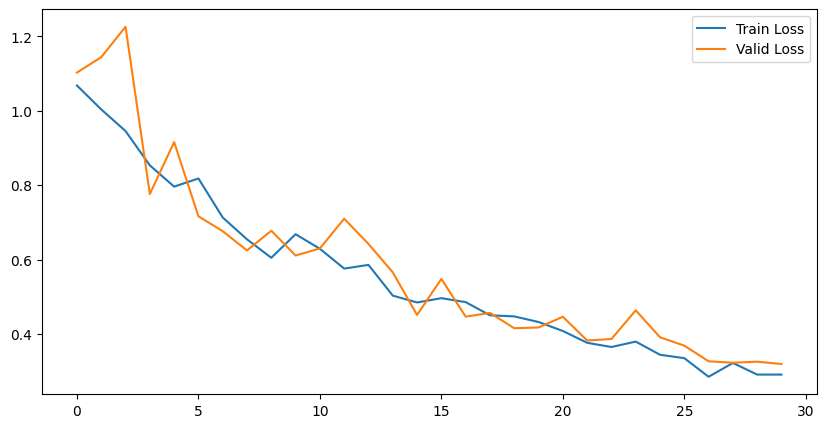

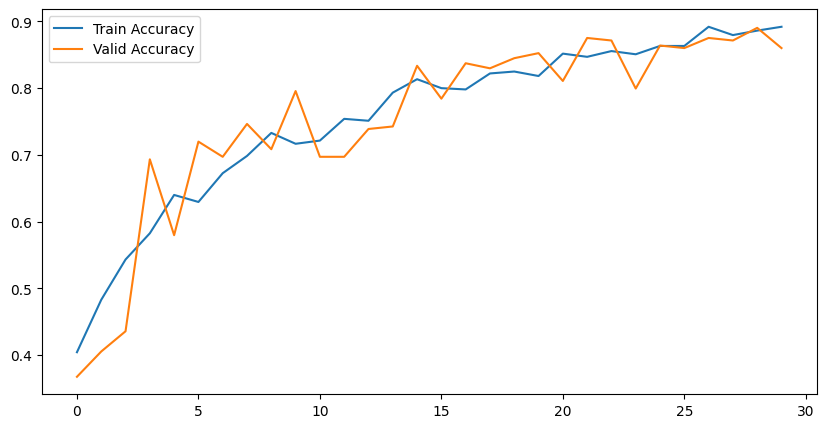

In [ ]:
plot_training_history(history)

In [12]:

# Evaluate test dataset
model_flexible.eval()
correct = 0
total = 0
device = 'cpu'

with torch.no_grad():
    for x_batch, y_batch in test_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        preds = model_flexible(x_batch)
        correct += (preds.argmax(dim=1) == y_batch).sum().item()
        total += y_batch.size(0)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8848


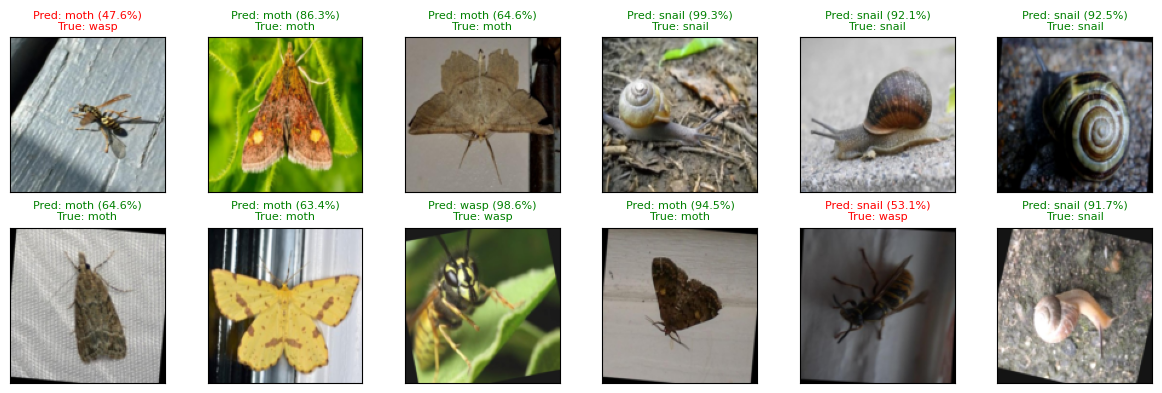

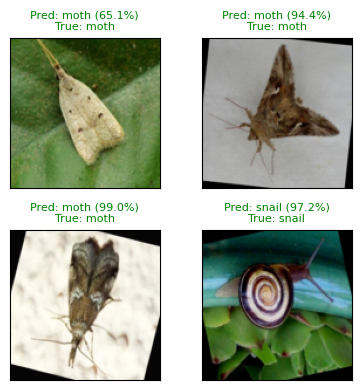

In [13]:
n_samples = 12
if len(test_dataset) > n_samples:
    # Auto layout (2x6 for 12 samples)
    plot_random_predictions(model_flexible, test_dataset, num_samples=n_samples, device="cpu")

n_samples = 4
if len(test_dataset) > n_samples:
    # Custom layout (2x2 for 4 samples)
    plot_random_predictions(model_flexible, test_dataset, num_samples=n_samples, rows=2, cols=2, device="cpu")

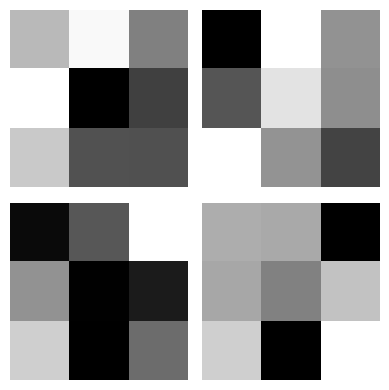

In [14]:
from source.plotting import plot_filter_weights

plot_filter_weights(model_flexible, rows=2, cols=2, channel=0) # channel as in RGB


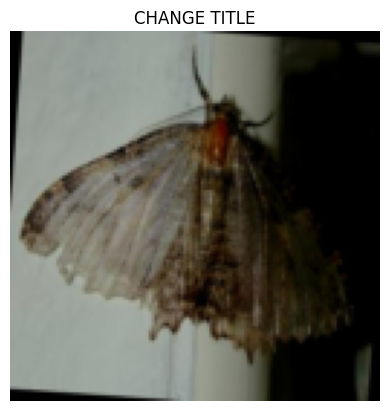

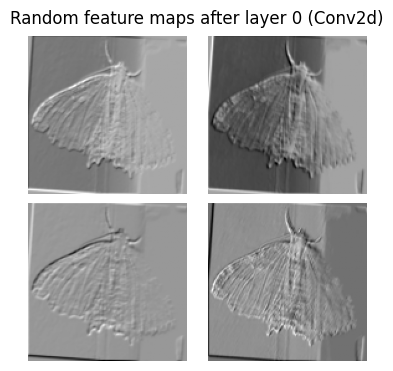

In [15]:
from source.plotting import plot_feature_maps, plot_image

sample_img, _ = test_dataset[0]

plot_image(sample_img)

plot_feature_maps(model_flexible, sample_img, layers_to_show=[0,3], num_maps=4, rows=2, cols=2, cmap='gray')

